# Run Tests

In [4]:
import time
import numpy as np
import csv
import os
from hcle_py.vector_env import HCLEVectorEnv

In [5]:
# --- Helper Functions ---

def simulate_agent_work(delay_ms: int):
    """This function simulates the time an agent would spend 'thinking' (e.g., a GPU forward pass)."""
    if delay_ms > 0:
        time.sleep(delay_ms / 1000.0)

def run_single_test(agent_think_time_ms: int, num_envs: int = 64, num_steps: int = 100):
    """
    Runs a single performance test for a given agent think time.
    
    Args:
        agent_think_time_ms: The simulated agent thinking time in milliseconds.
        num_envs: The number of parallel environments.
        num_steps: The number of steps to run the simulation for.
        
    Returns:
        A tuple containing the synchronous duration and asynchronous duration.
    """
    print(f"--- Testing with Agent Think Time: {agent_think_time_ms}ms ---")

    # Initialize the vectorized environment
    envs = HCLEVectorEnv(game="smb1", num_envs=num_envs, render_mode="rgb_array", maxpool=False, grayscale=True, stack_num=1)
    
    # --- 1. Synchronous Test ---
    envs.reset()
    start_time = time.time()
    for _ in range(num_steps):
        actions = envs.action_space.sample()
        obs, reward, terminated, truncated, info = envs.step(actions)
        simulate_agent_work(agent_think_time_ms)
    
    sync_duration = time.time() - start_time
    
    # --- 2. Asynchronous Test ---
    obs, info = envs.reset()
    actions = envs.action_space.sample()
    envs.step_async(actions)
    
    start_time = time.time()
    for _ in range(num_steps):
        simulate_agent_work(agent_think_time_ms)
        obs, reward, terminated, truncated, info = envs.step_wait()
        actions = envs.action_space.sample()
        envs.step_async(actions)
        
    async_duration = time.time() - start_time

    envs.close()
    
    print(f"Synchronous duration: {sync_duration:.4f}s, Asynchronous duration: {async_duration:.4f}s")
    
    return sync_duration, async_duration

In [8]:
# --- Main Execution Logic ---
while True:
    # Define the range of agent thinking times to test
    think_times_ms = np.arange(0, 16, 1).tolist() + np.arange(16, 129, 8).tolist()
    csv_filename = 'performance_results.csv'
    csv_headers = ['think_time', 'sync_duration', 'async_duration']

    # Check if the CSV file needs a header
    file_exists = os.path.isfile(csv_filename)

    # Open the CSV file in append mode
    with open(csv_filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write header if the file is new
        if not file_exists:
            writer.writerow(csv_headers)
            print(f"Created '{csv_filename}' with headers.")

        # Perform the tests and append results
        print(f"\n--- Starting new test run. Results will be appended to '{csv_filename}' ---")
        for think_time in think_times_ms:
            sync_d, async_d = run_single_test(agent_think_time_ms=think_time)
            writer.writerow([think_time, sync_d, async_d])
            csvfile.flush() # Ensure data is written immediately

    print("\n--- All Tests Complete ---")
    print(f"Results have been saved to '{csv_filename}'.")


--- Starting new test run. Results will be appended to 'performance_results.csv' ---
--- Testing with Agent Think Time: 0ms ---
Synchronous duration: 11.4859s, Asynchronous duration: 7.9736s
--- Testing with Agent Think Time: 1ms ---
Synchronous duration: 9.7321s, Asynchronous duration: 7.4097s
--- Testing with Agent Think Time: 2ms ---
Synchronous duration: 10.6255s, Asynchronous duration: 7.6911s
--- Testing with Agent Think Time: 3ms ---
Synchronous duration: 9.8297s, Asynchronous duration: 7.2188s
--- Testing with Agent Think Time: 4ms ---
Synchronous duration: 10.2100s, Asynchronous duration: 7.2775s
--- Testing with Agent Think Time: 5ms ---
Synchronous duration: 10.7217s, Asynchronous duration: 7.7603s
--- Testing with Agent Think Time: 6ms ---
Synchronous duration: 11.0336s, Asynchronous duration: 7.6799s
--- Testing with Agent Think Time: 7ms ---
Synchronous duration: 10.6840s, Asynchronous duration: 7.1750s
--- Testing with Agent Think Time: 8ms ---
Synchronous duration: 10.

KeyboardInterrupt: 

# Plot Data

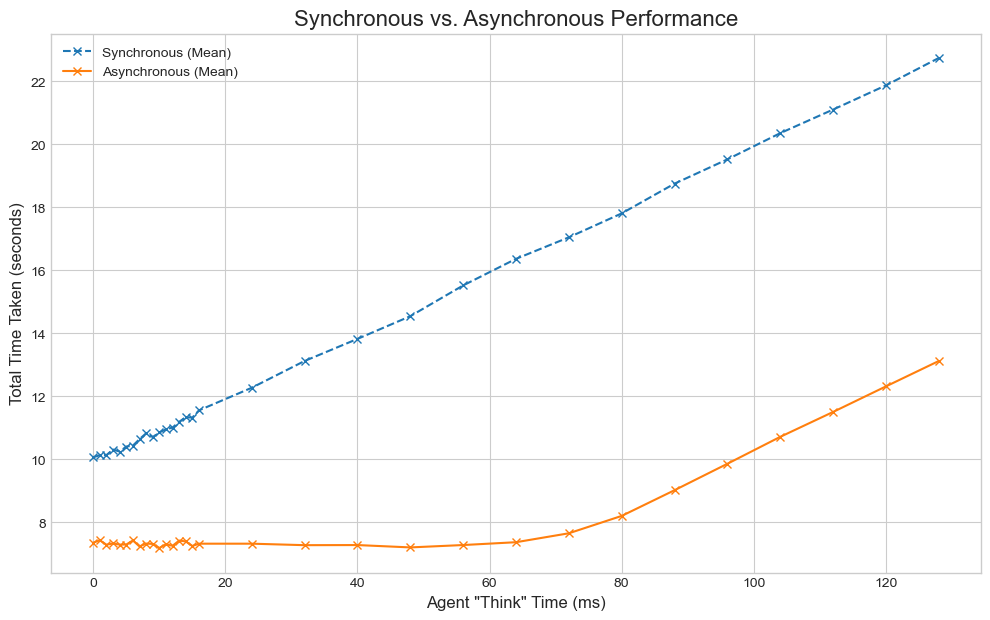

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('performance_results.csv')

summary = df.groupby('think_time').agg(
    sync_mean=('sync_duration', 'mean'),
    sync_std=('sync_duration', 'std'),
    async_mean=('async_duration', 'mean'),
    async_std=('async_duration', 'std')
).reset_index()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(
    summary['think_time'], 
    summary['sync_mean'], 
    # yerr=summary['sync_std'], 
    marker='x', 
    linestyle='--', 
    label='Synchronous (Mean)', 
    # capsize=2,
)

ax.plot(
    summary['think_time'], 
    summary['async_mean'], 
    # yerr=summary['async_std'], 
    marker='x', 
    linestyle='-', 
    label='Asynchronous (Mean)', 
    # capsize=2,
)

ax.set_title('Synchronous vs. Asynchronous Performance', fontsize=16)
ax.set_xlabel('Agent "Think" Time (ms)', fontsize=12)
ax.set_ylabel('Total Time Taken (seconds)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True)